In [ ]:
#%pip install yfinance numpy statsmodels pandas matplotlib arch openpyxl

In [1]:
%reset -f

##### Import Data
This cell imports index data from Yahoo Finance, using the yFinance library. Optionally, we can also make a backup of the data here.

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

# List of ticker symbols for each index
tickers = ["^GDAXI", "^AEX", "^N225", "^GSPC", "^GSPTSE"]  # DAX, AEX, Nikkei 225, S&P 500, TSX
index_datasets = {}

#Set to True to overwrite backup of data
#I used this to keep a backup, incase access to data was lost during the development of this program
OVERWRITE_DATA = False


# Loop over each ticker symbol to fetch the data
for ticker in tickers:
    # Retrieve the historical data starting from November 20, 1992
    index = yf.Ticker(ticker)
    #Save to dictionary
    index_datasets[ticker] = index.history(start="1992-11-20")
    # Convert the Date column to Datetime
    (index_datasets[ticker]).index = pd.to_datetime((index_datasets[ticker]).index.normalize().tz_localize(None))
    
    #Optional: Write data to disk
    if OVERWRITE_DATA: index_datasets[ticker].to_excel(".\\Data Backup\\"+ticker+'.xlsx', index=True)

##### Compute log-returns

We merge all of the data stored in the index_datasets dictionary into one Pandas dataframe. We sample the data on a quarterly basis, using a forward fill to account for any missing dates. The forward fill is required to account for different exchanges having different holidays. We then compute the quarterly log-returns for each index. We then drop all data apart from the date and quarterly log-returns from our dataframe.


In [19]:
# Initialize a DataFrame to store merged data
merged_data = pd.DataFrame()
k=0
# Loop over each ticker symbol to fetch the data
for ticker in tickers:
    
    index_data = index_datasets[ticker]

    # Extract only the Date and Close columns, reset the index
    close_data = (index_data[['Close']]).copy()

    close_data.rename(columns={'Close': ticker},inplace=True)

    
    # Merge with the previously merged data
    if merged_data.empty:
        merged_data = close_data
    else:
        merged_data = pd.merge(merged_data, close_data, on='Date')



for ticker in tickers:
    #Forward fill missing data
    merged_data[ticker] = merged_data[ticker].ffill()


#Resample at end of each quarter
merged_data = merged_data.resample("QE").last()

#Compute Log Returns
merged_data[:] = np.log(1+merged_data.pct_change())

#Alternatively, can use simple returns
#merged_data[:] = merged_data.pct_change()

merged_data.dropna(inplace=True)



##### Fit Models
Here, we first fit a Students-t GARCH model to the log-return data for each index, using the arch library.


Note: We are actually fitting the GARCH model to 100 times the log-return data, as recommended by the library documentation. This is done to improve numerical stability.


In [28]:
from arch import arch_model
from scipy.stats import t
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

#Fit GARCH model using a custom distribution for the residuals
#We will use dist = normal, t and skewt
def fit_garch(ts, dist):
    model = arch_model(ts, vol="Garch", p=1, q=1, dist=dist, rescale=False)
    return model.fit(disp="off")



print(fit_garch(merged_data["^GDAXI"], "normal"))
print()
print(fit_garch(merged_data["^GDAXI"], "t"))
print()
print(fit_garch(merged_data["^GDAXI"], "skewt"))


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 ^GDAXI   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                97.0874
Distribution:                  Normal   AIC:                          -186.175
Method:            Maximum Likelihood   BIC:                          -174.767
                                        No. Observations:                  128
Date:                Wed, Dec 11 2024   Df Residuals:                      127
Time:                        16:18:37   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0226  9.794e-03      2.304  2.124e-02 [3.

In [54]:
u_dict = {}
residuals_dict = {}

fitted_models = {}
models = ("normal","t","skewt")



norm_df,t_df,skewt_df = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()

#Fit each GARCH model for each index, store results in fitted_models dictionary
for model in models:
    for ticker in tickers:
        fitted_models[(ticker,model)] = fit_garch(merged_data[ticker]*100,model) #as suggested by the documentation, we scale our data to improve numerical stability
        #print(ticker, model)
        #print(fitted_models[(ticker,model)].params)

#Creates a dataframe with the fitted parameters from each model, and prints results
print("Fitted parameters for each model:\n")
for model in models:
    df = pd.DataFrame(columns=tickers)
    for ticker in tickers:
        df[ticker] = fitted_models[(ticker,model)].params
    print("\nModel: "+model)
    print(round(df,10))

Fitted parameters for each model:


Model: normal
             ^GDAXI       ^AEX      ^N225     ^GSPC    ^GSPTSE
mu         2.256275   2.225294   0.658129  2.193717   1.485514
omega     34.101196  27.560507  53.989657  8.488999  15.248494
alpha[1]   0.127338   0.306432   0.000000  0.311479   0.154563
beta[1]    0.621541   0.453440   0.501551  0.607396   0.621229

Model: t
             ^GDAXI       ^AEX       ^N225     ^GSPC    ^GSPTSE
mu         3.703774   3.074346    0.676412  3.085102   2.971922
omega     45.644488  42.360822   57.966267  8.259136  56.436246
alpha[1]   0.344919   0.409715    0.000000  0.363726   0.318989
beta[1]    0.498154   0.383073    0.465426  0.636274   0.101993
nu         3.066533   3.161394  227.828110  3.474692   2.981782

Model: skewt
             ^GDAXI       ^AEX       ^N225     ^GSPC    ^GSPTSE
mu         2.133236   1.751481    0.606702  1.944685   1.514557
omega     42.406194  37.011740   55.739032  8.017228  16.331895
alpha[1]   0.284236   0.347664    0

Recall that we scaled our log-returns by a factor of $100$ before fitting each model. Hence, our mean returns (mu) above are scaled by a factor of $100$, while our baseline variances (omega) are scaled by a factor of $100^2$

For each model, we note that there 


Observe the pronounced heavy tails in the log-return distributions of each index, with the exception of the Nikkei 225 log returns, which seem to follow a normal distribution.

##### Plot ACF of residuals

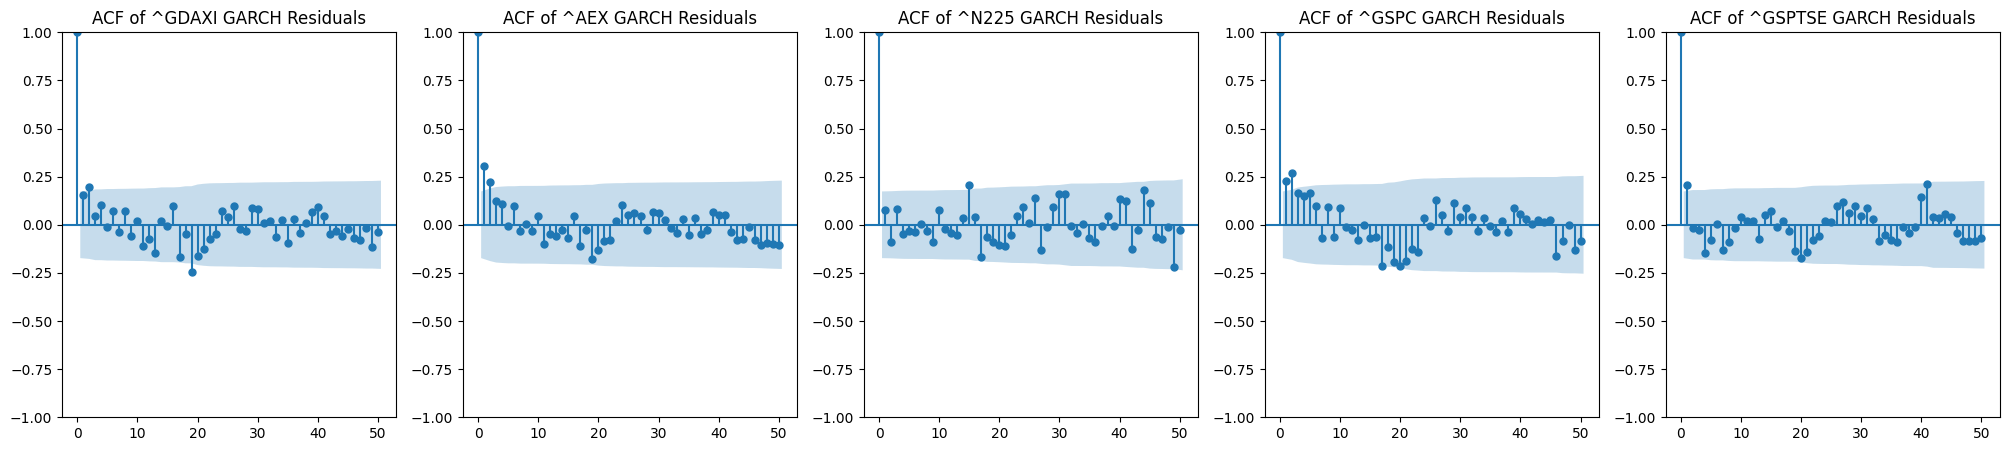

In [7]:
#This plots the ACF of the residuals of each GARCH, and displays them side by side for comparision
def plot_residual_acfs(residuals_dict):
    n_residuals = len(residuals_dict)
    fig, axes = plt.subplots(1, n_residuals, figsize=(5 * n_residuals, 5))

    for i in range(n_residuals):
        ticker = tickers[i]
        plot_acf(residuals_dict[ticker], lags=50, ax=axes[i])
        axes[i].set_title('ACF of ' + ticker + ' GARCH Residuals')

#Plot Results    
plot_residual_acfs(residuals_dict)


# Compute Spearman's Variance-Covariance Matrix
Using the residuals from our Student's t GARCH model, we calculate the spearman correlation of the residuals.

In [8]:
from scipy.stats import spearmanr


spearman_corr = spearmanr(list(residuals_dict.values()),axis=1)

# Calculate the standard deviations of the residuals
std_devs = []
for i in tickers:
    std_devs.append(np.std(residuals_dict[i]))
    plot

# Calculate the variance-covariance matrix
cov_matrix = np.float64(spearman_corr) * np.outer(std_devs, std_devs)



NameError: name 'plot' is not defined

In [ ]:

#Seed
np.random.seed(42) 

#Number Monte Carlo Simulations
n = 1000

simulated_data = np.random.multivariate_normal(np.zeros(len(tickers)),cov_matrix,n)


    

ValueError: cov must be 2 dimensional and square








# Step 1: Transform the data to uniform margins using ECDF (Empirical CDF)
uniform_data = pd.DataFrame()


# Use empirical CDF for each column (ticker) in the merged data
for ticker in tickers:
    uniform_data[ticker] = merged_data_filled[ticker].rank() / len(merged_data_filled[ticker])

# Step 2: Fit a copula (using Gaussian copula as an example)
copula = StudentTCopula()

# Step 3: Fit the copula to the uniform-transformed data
copula.fit(uniform_data)

# Step 4: Simulate synthetic data from the fitted copula (optional)
simulated_data = copula.sample(len(merged_data_filled))

# Convert the uniform data back to the original scale (inverse of the transformation)
simulated_data_original_scale = pd.DataFrame()

for idx, ticker in enumerate(tickers):
    # Inverse transform (since we used ECDF, we can approximate the inverse by using the quantiles)
    simulated_data_original_scale[ticker] = np.percentile(merged_data_filled[ticker], simulated_data[:, idx] * 100)

# View the simulated data
print(simulated_data_original_scale.head())


Note: you may need to restart the kernel to use updated packages.
